# Structured Matrices

We have seen how algebraic operations (`+`, `-`, `*`, `/`) are
well-defined for floating point numbers. Now we see how this allows us
to do (approximate) linear algebra operations on structured matrices. That is,
we consider the following structures:


1. _Dense_: this can be considered unstructured, where we need to store all entries in a
vector or matrix. Matrix multiplication reduces directly to standard algebraic operations. 
Solving linear systems with dense matrices will be discussed later.
2. _Triangular_: If a matrix is upper or lower triangular, we can immediately invert using
back-substitution. In practice we store a dense matrix and ignore the upper/lower entries.
3. _Banded_: If a matrix is zero apart from entries a fixed distance from  the diagonal it is
called banded and this allows for more efficient algorithms. We discuss diagonal, 
tridiagonal and bidiagonal
matrices.
4. _Orthogonal_: An orthogonal matrix $Q$ satisfies $Q^⊤ Q = I$, in other words, they are
very easy to invert. We discuss special cases includion permutations, rotations and reflections.


## 1. Dense vectors and matrices

A `Vector` of a primitive type (like `Int` or `Float64`) is stored
consecutively in memory. E.g. if we have a `Vector{Int8}` of length
`n` then it is stored as `8n` bits (`n` bytes) in a row.
A  `Matrix` is stored consecutively in memory, going down column-by-
column. That is,

In [1]:
A = [1 2; 3 4; 5 6]

3×2 Matrix{Int64}:
 1  2
 3  4
 5  6

Is actually stored equivalently to a length `6` vector:

In [2]:
vec(A)

6-element Vector{Int64}:
 1
 3
 5
 2
 4
 6

This is known as _column-major_ format.

**Remark** Note that transposing `A` is done lazyily and so `A'`
stores the entries by row. That is, `A'` is stored in 
_row-major_ format.


Matrix-vector multiplication works as expected:

In [3]:
x = [7, 8]
A*x

3-element Vector{Int64}:
 23
 53
 83

It is easy to implement matrix-multiplication in terms of the algebraic operations 
we have learned, in this case just using integer arithmetic:

In [4]:
function mul(A, x)
    m,n = size(A)
    c = zeros(eltype(x), m) # eltype is the type of the elements of a vector/matrix
    for j = 1:n, k = 1:m
        c[k] += A[k, j] * x[j]
    end
    c
end
mul(A, x)

3-element Vector{Int64}:
 23
 53
 83

**Remark (advanced)** 
This accesses the entries of `A` going down the column,
which happens to be _significantly faster_ than accessing by row due to the
way computers access memory, but this is beyond the scope of this module.




Note that the rules of arithmetic apply here: matrix multiplication with floats
will incur round-off error (the precise details of which are subject to the implementation):

In [5]:
A = [1.4 0.4;
     2.0 1/2]
A * [1, -1] # First entry has round-off error, but 2nd entry is exact

2-element Vector{Float64}:
 0.9999999999999999
 1.5

And integer arithmetic will be prone to overflow:

In [6]:
A = fill(Int8(2^6), 2, 2) # make a matrix whose entries are all equal to 2^6
A * Int8[1,1] # we have overflowed and get a negative number -2^7

2-element Vector{Int8}:
 -128
 -128

**Remark (advanced)** For floating point types, `A*x` is implemented in BLAS which is generally multi-threaded
and is not identical to `mul(A,x)`, that is, some inputs will differ in how the computations
are rounded.

Solving a linear system is done using `\`:

In [7]:
A = [1 2 3;
     1 2 4;
     3 7 8]
b = [10; 11; 12]
A \ b

3-element Vector{Float64}:
  41.000000000000036
 -17.000000000000014
   1.0

Despite the answer being integer-valued, 
here we see that it resorted to using floating point arithmetic,
incurring rounding error. 
But it is "accurate to (roughly) 16-digits".
As we shall see, the way solving a linear system works is we first write `A` as a
product of simpler matrices, e.g., a product of triangular matrices.

**Remark (advanced)** For floating point types, `A \ x` is implemented in LAPACK, which
like BLAS is generally multi-threaded and in fact different machines may round differently.


## 2. Triangular matrices

Triangular matrices are represented by dense square matrices where the entries below the
diagonal
are ignored:

In [8]:
A = [1 2 3;
     4 5 6;
     7 8 9]
U = UpperTriangular(A)

3×3 UpperTriangular{Int64, Matrix{Int64}}:
 1  2  3
 ⋅  5  6
 ⋅  ⋅  9

We can see that `U` is storing all the entries of `A`:

In [9]:
U.data

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

Similarly we can create a lower triangular matrix by ignoring the entries above the diagonal:

In [10]:
L = LowerTriangular(A)

3×3 LowerTriangular{Int64, Matrix{Int64}}:
 1  ⋅  ⋅
 4  5  ⋅
 7  8  9

If we know a matrix is triangular we can do matrix-vector multiplication in half
the number of operations. 
Moreover, we can easily invert matrices. 
Consider a simple 3×3 example, which can be solved with `\`:

In [11]:
b = [5,6,7]
x = U \ b

3-element Vector{Float64}:
 2.1333333333333333
 0.2666666666666666
 0.7777777777777778

Behind the seens, `\` is doing back-substitution: considering the last row, we have all
zeros apart from the last column so we know that `x[3]` must be equal to:

In [12]:
b[3] / U[3,3]

0.7777777777777778

Once we know `x[3]`, the second row states `U[2,2]*x[2] + U[2,3]*x[3] == b[2]`, rearranging
we get that `x[2]` must be:

In [13]:
(b[2] - U[2,3]*x[3])/U[2,2]

0.2666666666666666

Finally, the first row states `U[1,1]*x[1] + U[1,2]*x[2] + U[1,3]*x[3] == b[1]` i.e.
`x[1]` is equal to

In [14]:
(b[1] - U[1,2]*x[2] - U[1,3]*x[3])/U[1,1]

2.1333333333333333

The problem sheet will explore implementing this for general triangular matrices, as well
as forward substitution for inverting lower triangular matrices.


## 3. Banded matrices

A _banded matrix_ is zero off a prescribed number of diagonals. 
We call the number of (potentially) non-zero diagonals the _bandwidths_:


**Definition (bandwidths)** A matrix $A$ has _lower-bandwidth_ $l$ if 
$A[k,j] = 0$ for all $k > j+l$ and _upper-bandwidth_ $u$ if
$A[k,j] = 0$ for all $j > k+u$. We say that it has _strictly lower-bandwidth_ $l$
if it has lower-bandwidth $l$ and there exists a $j$ such that $A[j+l,j] \neq 0$.
We say that it has _strictly upper-bandwidth_ $u$
if it has upper-bandwidth $u$ and there exists a $k$ such that $A[k,k+u] \neq 0$.


### Diagonal

**Definition (Diagonal)** _Diagonal matrices_ are square matrices with bandwidths $l = u = 0$.


Diagonal matrices in Julia are stored as a vector containing the diagonal entries:

In [15]:
x = [1,2,3]
D = Diagonal(x)

3×3 Diagonal{Int64, Vector{Int64}}:
 1  ⋅  ⋅
 ⋅  2  ⋅
 ⋅  ⋅  3

It is clear that they can multiply and efficiently (in $O(n)$ operations).

### Bidiagonal

**Definition (Bidiagonal)** If a square matrix has bandwidths $(l,u) = (1,0)$ it is _lower-bidiagonal_ and
if it has bandwidths $(l,u) = (0,1)$ it is _upper-bidiagonal_.

### Tridiagonal

**Definition (Tridiagonal)** If a square matrix has bandwidths $l = u = 1$ it is _tridiagonal_.

Julia has 

Tridiagonal matrices will come up in second-order differential equations and orthogonal polynomials.
In this case the matrices are symmetric, and Julia has a special type `SymTridiagonal` for representing
symmetric-tridiagonal matrices:

## 4. Orthogonal matrices

**Definition (orthogonal matrix)** A square matrix is _orthogonal_ if its inverse is its transpose:
$$
Q^⊤ Q = QQ^⊤ = I.
$$

**Proposition (norm-preserving)** Orthogonal matrices preserve the 2-norm of vectors:
$$
\|Q 𝐯\|^2 = \|𝐯\|.
$$

**Proof**
$$
\|Q 𝐯\|^2 = (Q 𝐯)^⊤ Q 𝐯 = 𝐯^⊤ Q^⊤ Q 𝐯 = 𝐯^⊤  𝐯 = \|𝐯\|^2
$$
∎

Here we discuss three important cases: permutations, simple rotations and reflections.

### Permutation Matrices

Permutation matrices are matrices that represent the action of permuting the entries of a vector,
that is, matrix representations of the symmetric group $S_n$, acting on $ℝ^n$.
Recall every $σ \in S_n$ is a bisection between $\{1,2,\ldots,n\}$.
We can write a permutation $σ$ in _Cauchy notation_:
$$
\begin{pmatrix}
 1 & 2 & 3 & \cdots & n \cr
 σ_1 & σ_2 & σ_3 & \cdots & σ_n
 \end{pmatrix}
$$
where $\{σ_1,\ldots,σ_n\} = \{1,2,\ldots,n\}$ (that is, each integer appears precisely once).
We denote the _inverse permutation_ by $σ^{-1}$, which can be constructed by swapping the rows of
the Cauchy notation and reordering.

We can encode a permutation in vector $\mathbf σ = [σ_1,\ldots,σ_n]^⊤$. 
This induces an action on a vector (using indexing notation)
$$
𝐯[\mathbf σ] = \begin{pmatrix}v_{σ_1}\\ \vdots \\ v_{σ_n} \end{pmatrix}
$$


**Example (permutation of a vector)** 
Consider the permutation $σ$ given by
$$
\begin{pmatrix}
 1 & 2 & 3 & 4 & 5 \cr
 1 & 4 & 2 & 5 & 3
 \end{pmatrix}
$$
We can apply it to a vector of the first 5 letter:

In [16]:
σ = [1, 4, 2, 5, 3]
v = [6, 7, 8, 9, 10]
v[σ] # we permutate entries of v

5-element Vector{Int64}:
  6
  9
  7
 10
  8

Its inverse permutation $σ^{-1}$ has Cauchy notation coming from swapping the rows of
the Cauchy notation of $σ$ and sorting:
$$
\begin{pmatrix}
 1 & 4 & 2 & 5 & 3 \cr
 1 & 2 & 3 & 4 & 5
 \end{pmatrix} \rightarrow \begin{pmatrix}
 1 & 2 & 4 & 3 & 5 \cr
 1 & 3 & 2 & 5 & 4
 \end{pmatrix} 
$$
Julia has the function `invperm` for computing the vector that encodes
the inverse permutation:
And indeed:

In [17]:
σ⁻¹ = invperm(σ) # note that ⁻¹ are just unicode characters in the variable name

5-element Vector{Int64}:
 1
 3
 5
 2
 4

And indeed permuting the entries by `σ` and then by `σ⁻¹` returns us
to our original vector:

In [18]:
v[σ][σ⁻¹] # permuting by σ and then σⁱ gets us back

5-element Vector{Int64}:
  6
  7
  8
  9
 10

Note that the operator
$$
P_σ(𝐯) = 𝐯[\mathbf σ]
$$
is linear in $𝐯$, therefore, we can identify it with a matrix whose action is:
$$
P_σ \begin{pmatrix} v_1\\ \vdots \\ v_n \end{pmatrix} = \begin{pmatrix}v_{σ_1} \\ \vdots \\ v_{σ_n}  \end{pmatrix}.
$$
The entries of this matrix are
$$
P_σ[k,j] = 𝐞_k^⊤ P_σ 𝐞_j = 𝐞_k^⊤ 𝐞_{σ^{-1}_j} = δ_{k,σ^{-1}_j} = δ_{σ_k,j}
$$
where $δ_{k,j}$ is the _Kronecker delta_:
$$
δ_{k,j} := \begin{cases} 1 & k = j \\
                        0 & \hbox{otherwise}
                        \end{cases}.
$$


This construction motivates the following definition:

**Definition (permutation matrix)** $P \in ℝ^{n × n}$ is a permutation matrix if it is equal to
the identity matrix with its rows permuted.

**Example (5×5 permutation matrix)**
We can construct the permutation representation for $σ$ as above as follows:

In [19]:
P = I(5)[σ,:]

5×5 SparseMatrixCSC{Bool, Int64} with 5 stored entries:
 1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅
 ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅  ⋅

And indeed, we see its action is as expected:

In [20]:
P * v

5-element Vector{Int64}:
  6
  9
  7
 10
  8

**Remark (advanced)** Note that `P` is a special type `SparseMatrixCSC`. This is used
to represent a matrix by storing only the non-zero entries as well as their location.
This is an important data type in high-performance scientific computing, but we will not
be using general sparse matrices in this module.

**Proposition (permutation matrix inverse)** 
Let $P_σ$ be a permutation matrix corresponding to the permutation $σ$. Then
$$
P_σ^⊤ = P_{σ^{-1}} = P_σ^{-1}
$$
That is, $P_σ$ is _orthogonal_:
$$
P_σ^⊤ P_σ = P_σ P_σ^⊤ = I.
$$

**Proof**

We prove orthogonality via:
$$
𝐞_k^⊤ P_σ^⊤ P_σ 𝐞_j = (P_σ 𝐞_k)^⊤ P_σ 𝐞_j = 𝐞_{σ^{-1}_k}^⊤ 𝐞_{σ^{-1}_j} = δ_{k,j}
$$
This shows $P_σ^⊤ P_σ = I$ and hence $P_σ^{-1} = P_σ^⊤$. 

∎


Permutation matrices are examples of sparse matrices that can be very easily inverted. 


### Simple rotations


**Definition (simple rotation)**
A 2×2 _rotation matrix_ through angle $θ$ is
$$
Q_θ := \begin{pmatrix} \cos \theta & -\sin \theta \cr \sin \theta & \cos \theta \end{pmatrix}
$$

In what follows we use the following for writing the angle of a vector:

**Definition (two-arg arctan)** The two-argument arctan function gives the angle `θ` through the point
$[a,b]^\top$, i.e., 
$$
\sqrt{a^2 + b^2} \begin{pmatrix} \cos θ \\ \sin θ \end{pmatrix} =  \begin{pmatrix} a \\ b \end{pmatrix}
$$
It can be defined in terms of the standard arctan as follows:
$$
{\rm atan}(b,a) := \begin{cases} {\rm atan}{b \over a} & a > 0 \\
                            {\rm atan}{b \over a} + π & a < 0\hbox{ and }b >0 \\
                            {\rm atan}{b \over a} + π & a < 0\hbox{ and }b < 0 \\
                            π/2 & a = 0\hbox{ and }b >0 \\
                            -π/2 & a = 0\hbox{ and }b < 0 
                            \end{cases}
$$ 

This is available in Julia:

In [21]:
atan(-1,-2) # angle through [-2,-1]

-2.677945044588987

We can rotate an arbitrary vector to the unit axis. Interestingly it only requires
basic algebraic functions (no trigonometric functions):



**Proposition (rotation of vector)** 
The matrix
$$Q = {1 \over \sqrt{a^2 + b^2}}\begin{pmatrix}
 a & b \cr -b & a
\end{pmatrix}
$$
is a rotation matrix satisfying
$$
Q \begin{pmatrix} a \\ b \end{pmatrix} = \sqrt{a^2 + b^2} \begin{pmatrix} 1 \\ 0 \end{pmatrix}
$$

**Proof** 

The last equation is trivial so the only question is that is a a rotation matrix.
Define $θ = -{\rm atan}(b, a)$. By definition of the two-arg arctan we have
$$
\begin{pmatrix}
\cos θ & -\sin θ \\
\sin θ &\cos θ
\end{pmatrix} = \begin{pmatrix}
\cos(-θ) & \sin(-θ) \\
-\sin(-θ) & \cos(-θ)
\end{pmatrix} = {1\over \sqrt{a^2 + b^2}} \begin{pmatrix} a  & b \\ -b &a \end{pmatrix}.
$$

∎


 We can visualize this using Plots.jl, seeing that the 2-norm is preserved:

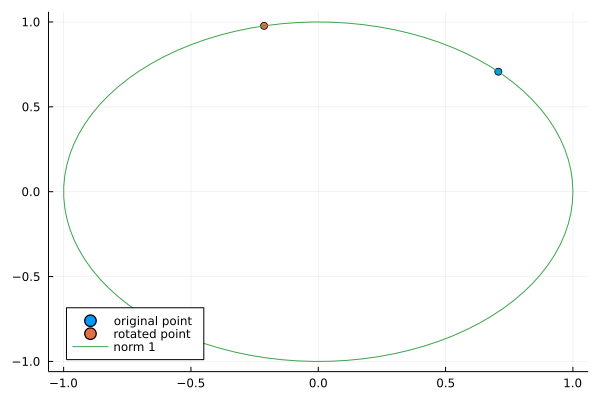

In [22]:
using Plots

θ = 1.     # rotation angle
Q = [cos(θ) -sin(θ);
    sin(θ) cos(θ)]    # rotation matrix

v = [1,1]/sqrt(2)      # point on the circle
Qv = Q*v               # rotated vector
x = Qv[1]     # x coordinate of the rotated vector
y = Qv[2]     # y coordinate of the rotated vector

scatter([v[1]], [v[2]]; label="original point", legend=:bottomleft)
scatter!([x], [y]; label="rotated point")

# now plot the circle
grid = range(0, 2π; length=100)       # plotting grid for the circle
plot!(cos.(grid), sin.(grid); label="norm 1")     # plot circle in red

### Rotations versus lower triangular matrices

On a computer, a point may have a small $\epsilon$ of error due to rounding.
Thus to understand the robustness of an algorithm, we need to understand what happens to balls of radius 
$\epsilon$ around where we think of the point. (We will make this more precise later.)
In the next lectures we will have a choice between using orthogonal and triangular matrices In
matrix decompositions. In terms of _stability_ (robustness to noise/round-off errors) 
decompositions built using orthogonal matrices are generally preferred, as we will now explain visually. 

We shall demonstrate why rotations are preferred to lower triangular operations.
In the following, we design a function that plots a circle around a point `[a,b]` of size `ε`, both before and after a matrix `L` is applied.
Here we demonstrate that the effect of `L` is to stretch the circles: our error can be amplified:

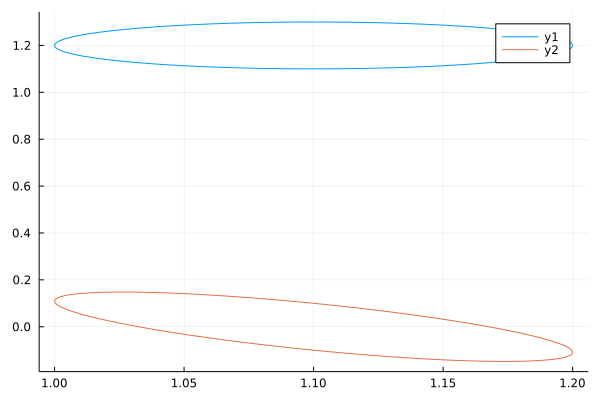

In [23]:
using Plots
function plotmat(a,b,ε,L)
    t = range(0, 2π; length=100)
    x,y = (a .+ ε*cos.(t), b .+ ε*sin.(t))
    plot(x, y)

    Lx = zeros(length(x))
    Ly = zeros(length(x))

    for k=1:length(x)
        Lx[k], Ly[k] = L*[x[k], y[k]]
    end
    plot!(Lx, Ly)
end

a,b = [1.1, 1.2]

L = [1    0;
     -b/a 1]

ε = 0.1

plotmat(a, b, ε, L)

As `a` becomes small, this error amplification becomes greater: in the following, we go from 
knowing the true point with accuracy 0.1 to only knowing it with about accuracy 1:

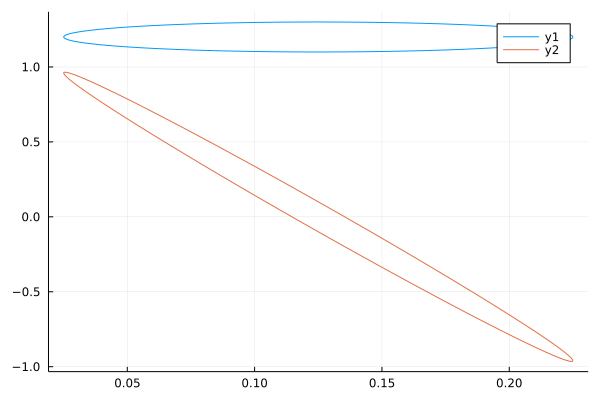

In [24]:
a,b = [0.125,1.2]

L = [1    0;
     -b/a 1]

ε = 0.1

plotmat(a, b, ε, L)

Rotations perform much better: the circles are only rotated, and are not magnified at all:

In [25]:
a,b=[1.1,1.2]

θ=-atan(b,a)
Q=[cos(θ) -sin(θ);
    sin(θ) cos(θ)]

ε=0.1

plotmat(a,b,ε,Q)
plotmat(0,b,ε,Q)

plotmat(2a,b,ε,Q; [-5,5,-5,5])

LoadError: syntax: invalid keyword argument syntax "[-5, 5, -5, 5]" around In[25]:12

### Reflections

In addition to rotations, another type of orthognal matrix are reflections:

**Definition (reflection matrix)** 
Given a vector $𝐯$ satisfying $\|𝐯\|=1$, the reflection matrix is the orthogonal matrix as
$$
Q_𝐯 \triangleq I - 2 𝐯 𝐯^⊤
$$

These are reflections in the direction of $𝐯$. We can show this as follows:

**Proposition** $Q_𝐯$ satisfies:
1. Symmetry
2. Orthogonality
2. $𝐯$ is an eigenvector of $Q_𝐯$ with eigenvalue $-1$
4. It is a rank-1 perturbation of $I$
3. $\det Q_𝐯 = -1$


**Proof**

Property 1 follows immediately. Property 2 follows from
$$
Q_𝐯^⊤ Q_𝐯 = Q_𝐯^2 = I - 4 𝐯 𝐯^⊤ + 4 𝐯 𝐯^⊤ 𝐯 𝐯^⊤ = I
$$
Property 3 follows since
$$
Q_𝐯 𝐯 = -𝐯
$$
Property 4 follows since $𝐯 𝐯^⊤$ is a rank-1 matrix as all rows are linear combinations of each other.
To see property 5, note there is a dimension $n-1$ space $W$ orthogonal to $𝐯$.
For $𝐰 \in W$ we have
$$
Q_𝐯 𝐰 = 𝐰
$$
In other words, $1$ is an eigenvalue with multiplicity $n-1$ and $-1$ is an eigenvalue with multiplicity 1,
and thus the product of the eigenvalues is $-1$.

∎



**Example (reflection through 2-vector)** Consider reflection through $𝐱 = [1,2]^\top$. 
We first need to normalise $𝐱$:
$$
𝐯 = {𝐱 \over \|𝐱\|} = \begin{pmatrix} {1 \over \sqrt{5}} \\ {2 \over \sqrt{5}} \end{pmatrix}
$$
Note this indeed has unit norm:
$$
\|𝐯\|^2 = {1 \over 5} + {4 \over 5} = 1.
$$
Thus the reflection matrix is:
$$
Q_𝐯 = I - 2 𝐯 𝐯^⊤ = \begin{pmatrix}1 \\ & 1 \end{pmatrix} - {2 \over 5} \begin{pmatrix} 1 & 2 \\ 2 & 4 \end{pmatrix}
 =  {1 \over 5} \begin{pmatrix} 3 & -4 \\ -4 & -3 \end{pmatrix}
$$
Indeed it is symmetric, and orthogonal. It sends $𝐱$ to $-𝐱$:
$$
Q_𝐯 𝐱 = {1 \over 5} \begin{pmatrix}3 - 8 \\ -4 - 6 \end{pmatrix} = -𝐱
$$
Ant vector orthogonal to $𝐱$, like $𝐲 = [-2,1]^\top$, is left fixed:
$$
Q_𝐯 𝐲 = {1 \over 5} \begin{pmatrix}-6 -4 \\ 8 - 3 \end{pmatrix} = 𝐲
$$